1. Đang load và chuẩn bị dữ liệu...
Chuẩn bị dữ liệu hoàn tất.

Bắt đầu huấn luyện model giảm chiều 'BasicAE'...
Epoch 10/200 | Val Loss: 0.138951
Epoch 20/200 | Val Loss: 0.135031
Epoch 30/200 | Val Loss: 0.130921
Epoch 40/200 | Val Loss: 0.130040
Epoch 50/200 | Val Loss: 0.125389
Early stopping được kích hoạt tại epoch 57.
Huấn luyện AE hoàn tất trong 530.96 giây.

Sử dụng encoder để giảm chiều dữ liệu...
Giảm chiều hoàn tất. Dữ liệu mới có 32 chiều.

3. Huấn luyện mô hình One-Class SVM...
Huấn luyện OCSVM hoàn tất.

4. Đánh giá mô hình trên tập test...
Threshold được đặt dựa trên val set: 0.3288 (cho target FPR ≈ 0.05)


==================== KẾT QUẢ ĐÁNH GIÁ ====================
AUC: 0.9625
Accuracy: 0.9299
Precision: 0.9487
Recall: 0.9089
F1-Score: 0.9284

5. Vẽ biểu đồ trực quan hóa...


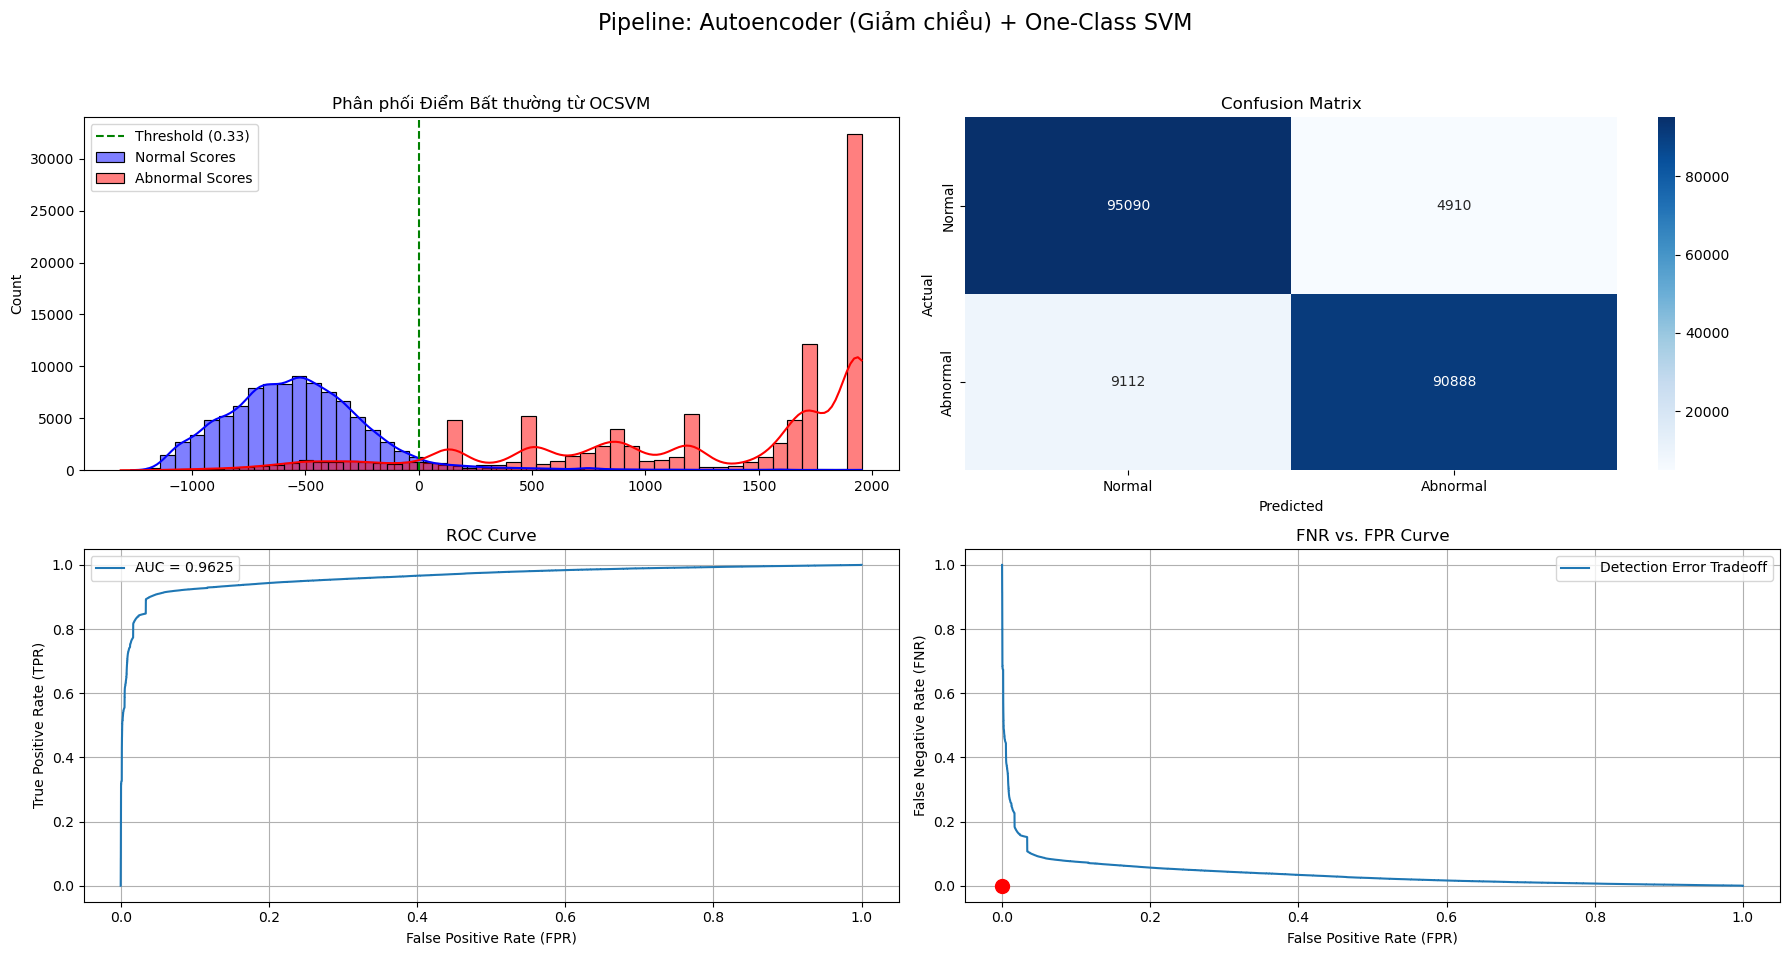

In [1]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from sklearn.preprocessing import StandardScaler
from sklearn.svm import OneClassSVM
from sklearn.metrics import roc_auc_score, accuracy_score, precision_recall_fscore_support, roc_curve, confusion_matrix, precision_recall_curve
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
import time
import warnings

# Tắt các cảnh báo không cần thiết
warnings.filterwarnings('ignore')

# ===================================================================
# GIAI ĐOẠN 1: MÔ HÌNH AUTOENCODER GIẢM CHIỀU
# ===================================================================

class BasicAE(nn.Module):
    """Mô hình Autoencoder để học biểu diễn và giảm chiều dữ liệu.
    Cải thiện: Thêm dropout để tránh overfitting và cải thiện generalization.
    """
    def __init__(self, input_dim, latent_dim=32):  # Tăng latent_dim từ 24 lên 32 để giữ nhiều thông tin hơn
        super(BasicAE, self).__init__()
        self.encoder = nn.Sequential(
            nn.Linear(input_dim, 64),
            nn.BatchNorm1d(64),
            nn.LeakyReLU(0.1),
            nn.Dropout(0.2),  # Thêm dropout
            nn.Linear(64, 32),
            nn.BatchNorm1d(32),
            nn.LeakyReLU(0.1),
            nn.Dropout(0.2),  # Thêm dropout
            nn.Linear(32, latent_dim)
        )
        self.decoder = nn.Sequential(
            nn.Linear(latent_dim, 32),
            nn.BatchNorm1d(32),
            nn.LeakyReLU(0.1),
            nn.Dropout(0.2),  # Thêm dropout
            nn.Linear(32, 64),
            nn.BatchNorm1d(64),
            nn.LeakyReLU(0.1),
            nn.Dropout(0.2),  # Thêm dropout
            nn.Linear(64, input_dim)
        )

    def forward(self, x):
        z = self.encoder(x)
        reconstructed = self.decoder(z)
        return reconstructed, z

def train_basic_ae(model, train_loader, val_loader, epochs, patience, learning_rate, model_save_path):
    """Hàm huấn luyện cho mô hình Autoencoder.
    Cải thiện: Giảm learning rate để huấn luyện ổn định hơn, tăng patience để tránh early stopping quá sớm.
    """
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)
    criterion = nn.MSELoss()
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)
    scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=5)
    
    best_val_loss = float('inf')
    epochs_no_improve = 0
    
    print(f"Bắt đầu huấn luyện model giảm chiều '{model.__class__.__name__}'...")
    start_time = time.time()
    
    for epoch in range(epochs):
        model.train()
        for (data,) in train_loader:
            data = data.to(device)
            optimizer.zero_grad()
            reconstructed, _ = model(data)
            loss = criterion(reconstructed, data)
            loss.backward()
            optimizer.step()
        
        model.eval()
        val_loss = 0
        with torch.no_grad():
            for (data,) in val_loader:
                data = data.to(device)
                reconstructed, _ = model(data)
                loss = criterion(reconstructed, data)
                val_loss += loss.item()
        
        avg_val_loss = val_loss / len(val_loader)
        scheduler.step(avg_val_loss)

        if (epoch + 1) % 10 == 0:
            print(f"Epoch {epoch+1}/{epochs} | Val Loss: {avg_val_loss:.6f}")
        
        if avg_val_loss < best_val_loss:
            best_val_loss = avg_val_loss
            torch.save(model.state_dict(), model_save_path)
            epochs_no_improve = 0
        else:
            epochs_no_improve += 1
        
        if epochs_no_improve >= patience:
            print(f"Early stopping được kích hoạt tại epoch {epoch+1}.")
            break
            
    end_time = time.time()
    print(f"Huấn luyện AE hoàn tất trong {end_time - start_time:.2f} giây.\n")
    model.load_state_dict(torch.load(model_save_path))
    return model

# ===================================================================
# SCRIPT CHÍNH
# ===================================================================
if __name__ == '__main__':
    # 1. Load và chuẩn bị dữ liệu
    print("1. Đang load và chuẩn bị dữ liệu...")
    try:
        X_train_raw = pd.read_csv('unsupervised_dataset.csv').apply(pd.to_numeric, errors='coerce').fillna(0).values
        test_df_raw = pd.read_csv('evaluation_dataset.csv')
        
        X_test_raw = test_df_raw.iloc[:, :-1].apply(pd.to_numeric, errors='coerce').fillna(0).values
        y_test_binary = np.where(test_df_raw.iloc[:, -1].values == -1, 1, 0) # 1 = Abnormal, 0 = Normal
    except Exception as e:
        print(f"Lỗi khi đọc file CSV: {e}")
        exit()

    # Scaling dữ liệu
    X_train_split, X_val_split = train_test_split(X_train_raw, test_size=0.2, random_state=42)
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train_split)
    X_val_scaled = scaler.transform(X_val_split)
    X_test_scaled = scaler.transform(X_test_raw)
    print("Chuẩn bị dữ liệu hoàn tất.\n")

    # 2. GIAI ĐOẠN 1: Huấn luyện AE và giảm chiều
    LATENT_DIM = 32  # Tăng từ 24 lên 32 để giữ nhiều đặc trưng hơn, giúp OCSVM phân biệt tốt hơn
    ae_model = BasicAE(input_dim=X_train_raw.shape[1], latent_dim=LATENT_DIM)
    
    train_ae_loader = DataLoader(TensorDataset(torch.FloatTensor(X_train_scaled)), batch_size=256, shuffle=True)
    val_ae_loader = DataLoader(TensorDataset(torch.FloatTensor(X_val_scaled)), batch_size=256, shuffle=False)
    
    ae_model = train_basic_ae(ae_model, train_ae_loader, val_ae_loader,
                              epochs=200,  # Tăng epochs
                              patience=20,  # Tăng patience
                              learning_rate=5e-4,  # Giảm learning rate để huấn luyện mịn hơn
                              model_save_path="best_ae_for_ocsvm.pth")

    # Sử dụng encoder để giảm chiều
    print("Sử dụng encoder để giảm chiều dữ liệu...")
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    encoder_part = ae_model.encoder.to(device).eval()
    with torch.no_grad():
        latent_train = encoder_part(torch.FloatTensor(X_train_scaled).to(device)).cpu().numpy()
        latent_val = encoder_part(torch.FloatTensor(X_val_scaled).to(device)).cpu().numpy()  # Thêm latent_val để tune threshold
        latent_test = encoder_part(torch.FloatTensor(X_test_scaled).to(device)).cpu().numpy()
    print(f"Giảm chiều hoàn tất. Dữ liệu mới có {latent_train.shape[1]} chiều.\n")

    # 3. GIAI ĐOẠN 2: Huấn luyện One-Class SVM trên không gian tiềm ẩn
    print("3. Huấn luyện mô hình One-Class SVM...")
    # Cải thiện: Tăng nu lên 0.05 để cho phép nhiều outliers hơn trong train, giúp tăng Recall
    # Thay gamma='scale' thay vì 'auto' để điều chỉnh tốt hơn dựa trên variance dữ liệu
    anomaly_model = OneClassSVM(nu=0.05, kernel="rbf", gamma='scale')
    anomaly_model.fit(latent_train)
    print("Huấn luyện OCSVM hoàn tất.\n")

    # 4. Đánh giá mô hình
    print("4. Đánh giá mô hình trên tập test...")
    # decision_function cho điểm bất thường. Đảo dấu để cao hơn nghĩa là bất thường hơn.
    test_scores = -anomaly_model.decision_function(latent_test)

    # Cải thiện: Sử dụng validation set (normal data) để đặt threshold dựa trên target FPR mong muốn
    # Điều này giúp kiểm soát FPR và tăng Recall bằng cách thư giãn threshold
    val_scores = -anomaly_model.decision_function(latent_val)
    target_fpr = 0.05  # Target FPR trên val set (5%), tăng từ ~1% để cải thiện Recall
    threshold = np.percentile(val_scores, 100 - (target_fpr * 100))  # Threshold để khoảng target_fpr % val bị classify abnormal
    print(f"Threshold được đặt dựa trên val set: {threshold:.4f} (cho target FPR ≈ {target_fpr})\n")

    # Dự đoán dựa trên threshold tùy chỉnh
    y_pred_binary = np.where(test_scores > threshold, 1, 0)  # 1 = Abnormal nếu score > threshold
    
    # Tính toán các chỉ số
    auc = roc_auc_score(y_test_binary, test_scores)
    accuracy = accuracy_score(y_test_binary, y_pred_binary)
    precision, recall, f1, _ = precision_recall_fscore_support(y_test_binary, y_pred_binary, average='binary')

    print("\n" + "="*20 + " KẾT QUẢ ĐÁNH GIÁ " + "="*20)
    print(f"AUC: {auc:.4f}")
    print(f"Accuracy: {accuracy:.4f}")
    print(f"Precision: {precision:.4f}")
    print(f"Recall: {recall:.4f}")
    print(f"F1-Score: {f1:.4f}")
    print("="*58 + "\n")
    
    # 5. Trực quan hóa (Giữ nguyên, nhưng cập nhật với threshold mới)
    print("5. Vẽ biểu đồ trực quan hóa...")
    plt.figure(figsize=(18, 10))
    plt.suptitle("Pipeline: Autoencoder (Giảm chiều) + One-Class SVM", fontsize=16)
    
    # Phân phối điểm bất thường
    plt.subplot(2, 2, 1)
    sns.histplot(test_scores[y_test_binary==0], color='blue', label='Normal Scores', kde=True, bins=50)
    sns.histplot(test_scores[y_test_binary==1], color='red', label='Abnormal Scores', kde=True, bins=50)
    plt.axvline(threshold, color='green', linestyle='--', label=f'Threshold ({threshold:.2f})')
    plt.title('Phân phối Điểm Bất thường từ OCSVM')
    plt.legend()

    # Ma trận nhầm lẫn
    plt.subplot(2, 2, 2)
    cm = confusion_matrix(y_test_binary, y_pred_binary)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Normal', 'Abnormal'], yticklabels=['Normal', 'Abnormal'])
    plt.title('Confusion Matrix')
    plt.xlabel('Predicted'); plt.ylabel('Actual')

    # ROC Curve
    plt.subplot(2, 2, 3)
    fpr, tpr, _ = roc_curve(y_test_binary, test_scores)
    plt.plot(fpr, tpr, label=f'AUC = {auc:.4f}')
    plt.title('ROC Curve'); plt.xlabel('False Positive Rate (FPR)'); plt.ylabel('True Positive Rate (TPR)')
    plt.legend(); plt.grid(True)

    # FNR vs. FPR Curve
    plt.subplot(2, 2, 4)
    fnr = 1 - tpr
    plt.plot(fpr, fnr, label='Detection Error Tradeoff')
    plt.title('FNR vs. FPR Curve'); plt.xlabel('False Positive Rate (FPR)'); plt.ylabel('False Negative Rate (FNR)')
    plt.legend(); plt.grid(True)
    plt.scatter(0, 0, marker='o', color='red', zorder=5, s=100, label='Ideal Point (FPR=0, FNR=0)')

    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    plt.savefig("final_evaluation_charts_with_fnr.png")
    plt.show()